In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib notebook
import threading

997
float32


<IPython.core.display.Javascript object>


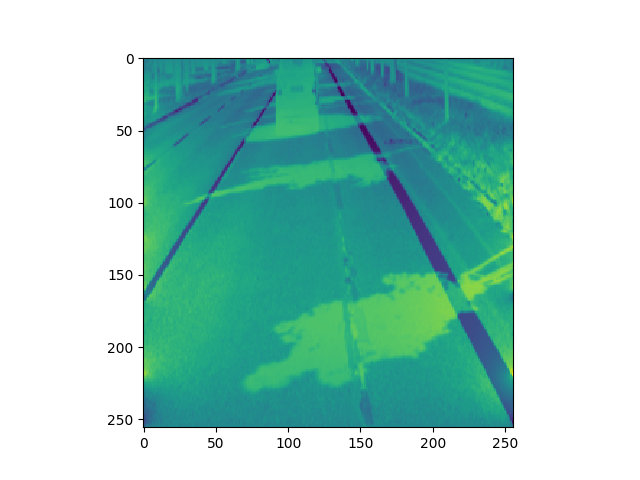

In [5]:
class SampleInput:
    
    def __init__(self,path,cache_size=8,target_size=(256,256)):
        import glob
        self.file_list = []
        for single_path in path:
            self.file_list.extend(glob.glob("{}/*.png".format(single_path)))
            
        print len(self.file_list)
        self.cache = []
        self.cache_size = cache_size
        self.target_size = target_size
        self.read_task = threading.Thread(target=self.read_task)
        self.read_task.start()
        
    def read_task(self):
        sampled = np.random.choice(len(self.file_list),self.cache_size)
        for each in sampled:
            im = cv2.imread(self.file_list[each],-1)
            im = im[im.shape[0]/2:,im.shape[1]/3:2*im.shape[1]/3]
            im = cv2.resize(im,self.target_size)
            im = im[:,:,np.newaxis].astype(np.float32)
            im -= 127
            im /= 127
            self.cache.append(im)
    
    
    def sample(self):
        self.read_task.join()
        to_ret = np.array(self.cache)
        self.cache = []
        del self.read_task
        self.read_task = threading.Thread(target=self.read_task)
        self.read_task.start()
        return to_ret

    
S = SampleInput(["../data/2011_09_26/2011_09_26_drive_0018_sync/image_00/data/",
                 "../data/2011_09_26/2011_09_26_drive_0056_sync/image_00/data/",
                 "../data/2011_09_26/2011_09_26_drive_0093_sync/image_00/data/"])
R = S.sample()
print R.dtype
plt.imshow(R[0,:,:,0],cmap='gray')


In [9]:
import scipy
import scipy.sparse
import pyamg
I = R[0,:,:,0]
I = cv2.Laplacian(I,cv2.CV_32F)
region_size = I.shape

A = scipy.sparse.identity(np.prod(region_size), format='lil')
for y in range(region_size[0]):
        for x in range(region_size[1]):
                index = x + y * region_size[1]
                A[index, index] = 4
                if index + 1 < np.prod(region_size):
                    A[index, index + 1] = -1
                if index - 1 >= 0:
                    A[index, index - 1] = -1
                if index + region_size[1] < np.prod(region_size):
                    A[index, index + region_size[1]] = -1
                if index - region_size[1] >= 0:
                    A[index, index - region_size[1]] = -1
A = A.tocsr()
x = pyamg.solve(A, I.flatten(), verb=True, tol=1e-10)

  Detected a Hermitian matrix
    maxiter = 400
    iteration 1
    iteration 2
    iteration 3
    iteration 4
    iteration 5
    iteration 6
    iteration 7
    iteration 8
    iteration 9
    iteration 10
    iteration 11
  Residuals ||r_k||_M, ||r_0||_M = 5.38e-09, 1.50e+02
  Residual reduction ||r_k||_M/||r_0||_M = 3.58e-11


In [10]:
x = x.reshape(-1,256)

<IPython.core.display.Javascript object>


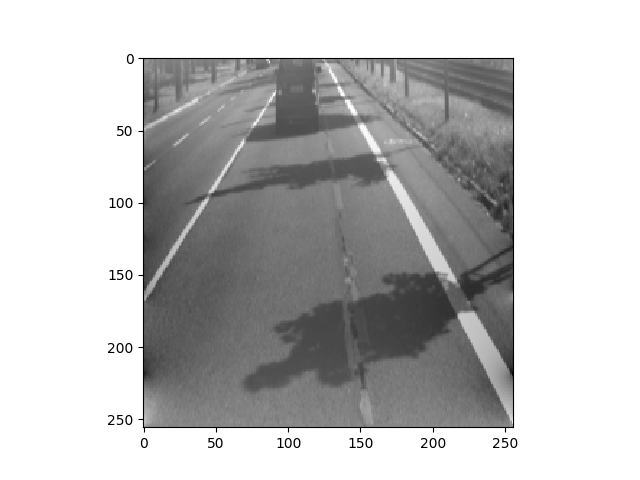

<IPython.core.display.Javascript object>


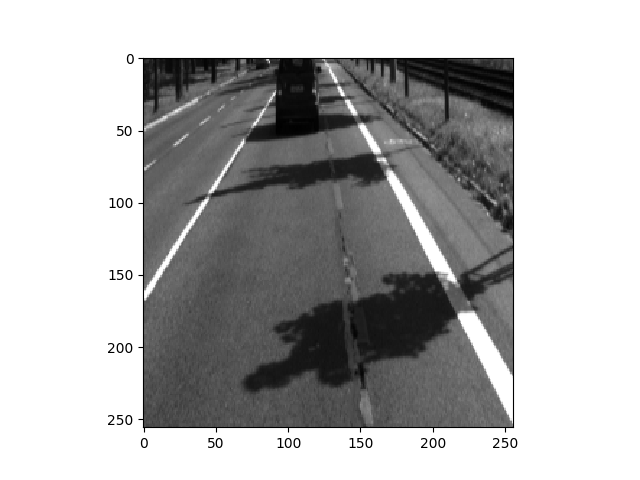

In [19]:
%matplotlib notebook
plt.figure()
plt.imshow(1 - x,cmap='gray')
plt.figure()
plt.imshow(R[0,:,:,0],cmap='gray')

In [17]:
plt.imshow(R[0,:,:,0],cmap='gray')